# Занятие 3: Метод k-ближайших соседей

In [134]:
# https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761

## Загружаем библиотеки

In [34]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import requests
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from scipy import stats
from scipy.interpolate import interp1d
from scipy import optimize

import csv

## Загружаем и анализируем датасет о пожизненной ценности клиента

In [2]:
# https://en.wikipedia.org/wiki/Churn_rate
data_file = "../data/Telco_customer_churn_2020.csv"
df = pd.read_csv(data_file, encoding = "utf-8" , engine='python')

print(df.columns)
print(df.shape)

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')
(7043, 33)


In [3]:
# Оставим только числа
num_cols = [col for col in df.columns.values if is_numeric_dtype(df[col])]
df = df[num_cols]
df = df.astype(float)

print(df.columns)

Index(['Count', 'Zip Code', 'Latitude', 'Longitude', 'Tenure Months',
       'Monthly Charges', 'Churn Value', 'Churn Score', 'CLTV'],
      dtype='object')


In [4]:
# Посмотрим корреляции
for col in df.columns.values:
    print(col, " corr: ", df[col].corr(df['Churn Value']))

Count  corr:  nan
Zip Code  corr:  0.0033464802711836786
Latitude  corr:  -0.0033844365616311997
Longitude  corr:  0.004593811469422537
Tenure Months  corr:  -0.3522286701130772
Monthly Charges  corr:  0.19335642223784674
Churn Value  corr:  1.0
Churn Score  corr:  0.6648970311816232
CLTV  corr:  -0.1274631017174495


### Объединяем

In [5]:
df_tenure =  df['Tenure Months']
df_charges = df['Monthly Charges']
df_churn = df['Churn Value']
df = pd.concat([df_tenure, df_charges, df_churn], axis=1).dropna()

### Визуализируем данные

No handles with labels found to put in legend.


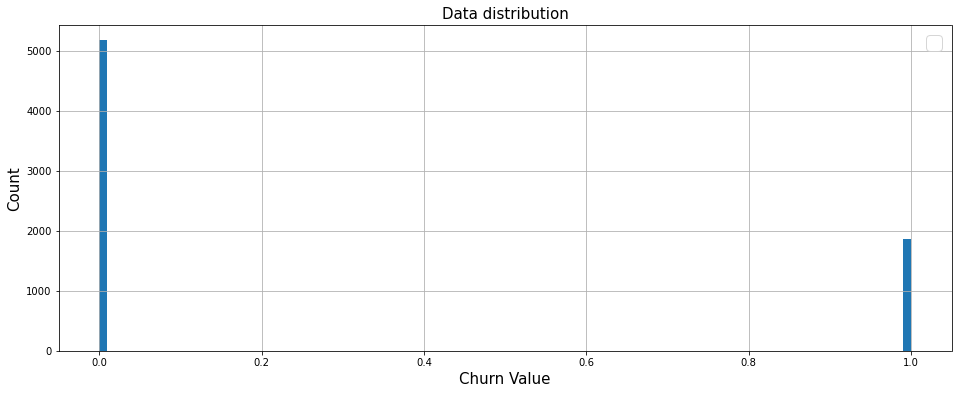

In [6]:
df['Churn Value'].hist(bins=100, figsize=(16,6))
plt.title('Data distribution', fontsize=15)
plt.xlabel('Churn Value', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=20)
plt.show()

No handles with labels found to put in legend.


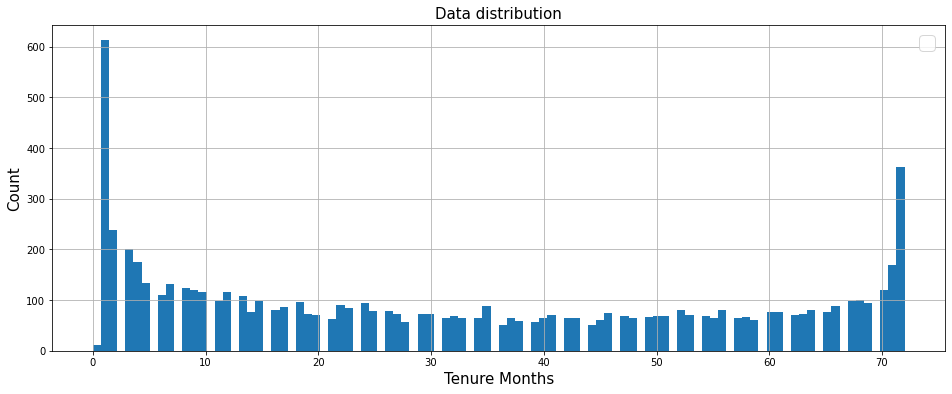

In [7]:
df['Tenure Months'].hist(bins=100, figsize=(16,6))
plt.title('Data distribution', fontsize=15)
plt.xlabel('Tenure Months', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=20)
plt.show()

No handles with labels found to put in legend.


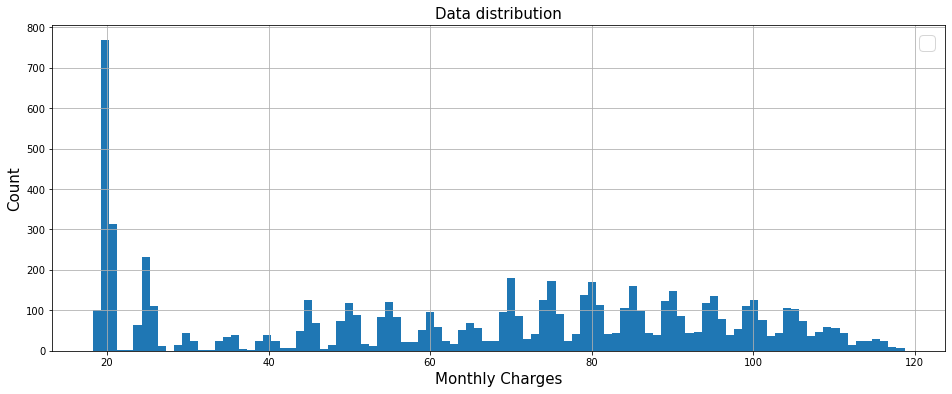

In [8]:
df['Monthly Charges'].hist(bins=100, figsize=(16,6))
plt.title('Data distribution', fontsize=15)
plt.xlabel('Monthly Charges', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=20)
plt.show()

<AxesSubplot:xlabel='Churn Value', ylabel='Monthly Charges'>

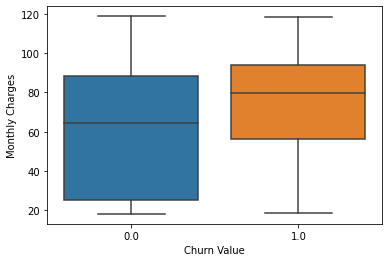

In [9]:
sns.boxplot(x = df["Churn Value"], y = df["Monthly Charges"])

<AxesSubplot:xlabel='Churn Value', ylabel='Tenure Months'>

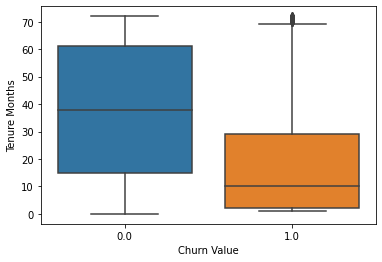

In [10]:
sns.boxplot(x = df["Churn Value"], y = df["Tenure Months"])

## Найдем и уберем outlier

In [11]:
# Найти outlier
z = np.abs(stats.zscore(df))
threshold = 3
print(np.where(z > threshold))

# Убрать outlier
df = df[(z < threshold).all(axis=1)]

(array([], dtype=int64), array([], dtype=int64))


## Нормализируем дата

In [12]:
# Длительность подписки
mu_duration = df['Tenure Months'].mean()
sigma_duration = df['Tenure Months'].std()
scaled_duration = (df['Tenure Months'].values-mu_duration)/sigma_duration

# Ежемесячные покупки
mu_charges = df['Monthly Charges'].mean()
sigma_charges = df['Monthly Charges'].std()
scaled_charges = (df['Monthly Charges'].values-mu_charges)/sigma_charges

x_data =np.array([scaled_duration,scaled_charges]).transpose()

# churn
y_data = np.expand_dims(df['Churn Value'], axis=1)

## Разделяем дата на выборки

In [13]:
# 20% данных будем использовать как validation dataset
val_size = 0.2

X_train, X_val, y_train, y_val = train_test_split(x_data, y_data, test_size=val_size, shuffle=True)
print('Data points in train set: {0}.'.format(len(X_train)))
print('Data points in val set: {0}.'.format(len(X_val)))
print("Shape of features in training data: {}".format(X_train.shape))
print("Shape of output in training data: {}".format(y_train.shape))
print("Shape of features in val data: {}".format(X_val.shape))
print("Shape of output in val data: {}".format(y_val.shape))

Data points in train set: 5634.
Data points in val set: 1409.
Shape of features in training data: (5634, 2)
Shape of output in training data: (5634, 1)
Shape of features in val data: (1409, 2)
Shape of output in val data: (1409, 1)


## Применяем метод К ближайших соседей

In [21]:
# Потроим "модель"
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
K = 15
knn = KNeighborsClassifier(n_neighbors=K) #, weights = "distance")
knn.fit(X_train, y_train)

# Применяем
y_pred = knn.predict(X_val)

# Посчитаем качество прогнозов
acc_sc = accuracy_score(y_val, y_pred) 
print("Acc:", acc_sc)

# https://en.wikipedia.org/wiki/Precision_and_recall
prec = precision_score(y_val, y_pred)
print("Prec:", prec)

rec = recall_score(y_val, y_pred)
print("Rec:", rec)

# https://en.wikipedia.org/wiki/F-score
f1_sc = f1_score(y_val, y_pred)
print("F1 score: ", f1_sc)

Acc: 0.7821149751596878
Prec: 0.6293436293436293
Rec: 0.4358288770053476
F1 score:  0.5150078988941549


/home/tarask/anaconda3/envs/robot_dreams/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """


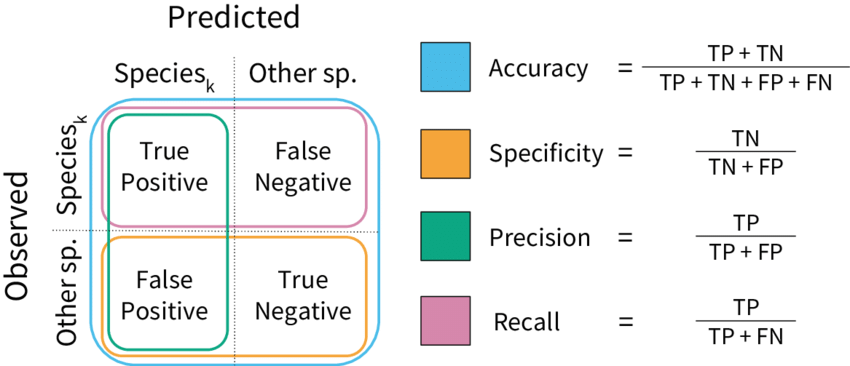

In [30]:
from IPython.display import Image
Image(filename='files/metrics.png')


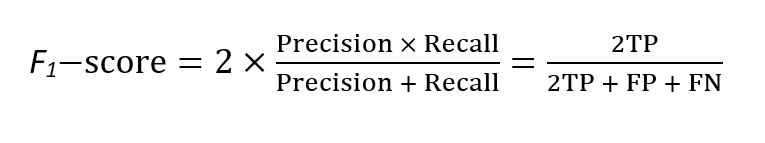

In [32]:
from IPython.display import Image
Image(filename='files/f1_score.png')


## Сравним с линейной регрессией

In [22]:
# Построим регрессию
regr = LinearRegression()
regr.fit(X_train, y_train)

# прогнозируем
y_pred = regr.predict(X_val)

# Округлим чтобы сделать прогноз 1 или 0
y_pred = y_pred.round()

# https://en.wikipedia.org/wiki/Precision_and_recall
prec = precision_score(y_val, y_pred)
print("Prec:", prec)

rec = recall_score(y_val, y_pred)
print("Rec:", rec)

# https://en.wikipedia.org/wiki/F-score
f1_sc = f1_score(y_val, y_pred)
print("F1 score: ", f1_sc)

Prec: 0.6885245901639344
Rec: 0.33689839572192515
F1 score:  0.45242369838420116


## Сравним с полиномиальной регрессией

In [25]:
# Построить регрессию
# Задаем степень полинома
polynomial_degree = 9

# Описиваем полиновиальную регрессию
polyreg = make_pipeline(
        PolynomialFeatures(degree=polynomial_degree),
        LinearRegression()
        )

# Находим коефициенты
polyreg.fit(X_train, y_train)

# Предсказываем
poly_pred = polyreg.predict(X_val).round()


acc_sc = accuracy_score(y_val, poly_pred) # normalize=False)
print("Acc:", acc_sc)

# https://en.wikipedia.org/wiki/Precision_and_recall
prec = precision_score(y_val, poly_pred)
print("Prec:", prec)

rec = recall_score(y_val, poly_pred)
print("Rec:", rec)

f1_sc = f1_score(y_val, poly_pred) # normalize=False)
print("F1 score: ", f1_sc)

Acc: 0.794180269694819
Prec: 0.6858407079646017
Rec: 0.4144385026737968
F1 score:  0.5166666666666666


In [26]:
# побробуем разные значения К

## Сравним с логистической регрессией

In [27]:
# Построим логистическую регрессию
logis_reg = LogisticRegression()

# Находим коефициенты
logis_reg.fit(X_train, y_train)

# Предсказываем
log_pred = logis_reg.predict(X_val).round()


acc_sc = accuracy_score(y_val, log_pred) 
print("Acc:", acc_sc)

prec = precision_score(y_val, log_pred)
print("Prec:", prec)

rec = recall_score(y_val, pred)
print("Rec:", rec)

f1_sc = f1_score(y_val, log_pred)
print("F1 score: ", f1_sc)




Acc: 0.7771469127040455
Prec: 0.6239669421487604
Rec: 0.4037433155080214
F1 score:  0.49025974025974023


/home/tarask/anaconda3/envs/robot_dreams/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
